In [11]:
import os
import sys; sys.path.append("~/HHbbgg_ETH_devel/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)
import ROOT
from ROOT import TChain, TTree,TCanvas,TH1F,TList,TFile,TH2F,TPaveLabel,TPaveText,TLorentzVector

## Create root file for creating a histogram needed for nodes reweighting

In [2]:
#file_dir = '/shome/nchernya/CMSSW_9_4_9/src/flashgg/output_oldnodes2016_30_01_2018/'   #2016 old nodes
file_dir = '/shome/nchernya/HHbbgg_ETH_devel/root_files/HHreweighting_01_02_2018/'   #2017 nodes 
out_dir = '/shome/nchernya/HHbbgg_ETH_devel/root_files/HHreweighting_01_02_2018/'
year = '2017'
#outname = 'output_GluGluToHHTo2B2G_mix12nodes_13TeV-madgraph_%s.root'%year
outname = 'output_GluGluToHHTo2B2G_mix6nodes_13TeV-madgraph_%s.root'%year
#inname = 'output_GluGluToHHTo2B2G_12nodes_13TeV-madgraph.root'
inname = 'output_GluGluToHHTo2B2G_6nodes_13TeV-madgraph_correctedcfg.root'
chainsGen = []


In [ ]:
out = TFile(out_dir+outname,'recreate')
gen_events_per_node = []
filename = file_dir+inname    
file = TFile(filename)
dirGen = file.GetDirectory('genDiphotonDumper')
dirGen = dirGen.GetDirectory('trees')
tlistGen = TList()
#for i in range(2,14): #for 2016
for i in [2,3,4,7,9,12]: #for 2017
    name = 'GluGluToHHTo2B2G_node_%d_13TeV_madgraph_correctedcfg_13TeV_DoubleHTag_0'%(i)
    name_all = 'GluGluToHHTo2B2G_node_%d_13TeV_madgraph_correctedcfg_13TeV_NoTag_0'%(i)
    treeGen = dirGen.Get(name)
    treeGen_all = dirGen.Get(name_all)
    tlistGen.Add(treeGen)
    tlistGen.Add(treeGen_all)
out.cd()
newtreeGen = (TTree.MergeTrees(tlistGen)).Clone('GluGluToHHTo2B2G_mixnodes_GenAll')
newtreeGen.SetName('GluGluToHHTo2B2G_mixnodes_GenAll')
newtreeGen.Write()
out.Close()

## Check reweighted nodes

In [16]:
file_dir = '/shome/nchernya/HHbbgg_ETH_devel/root_files/'
file_dir_tag = 'HHreweighted_12_02_2018/'
file_dir +=file_dir_tag
out_dir = file_dir
#year = '2016'
#inname = 'output_GluGluToHHTo2B2G_mixReweightedNodes_13TeV-madgraph'
year = '2017'
inname = 'output_GluGluToHHTo2B2G_mixReweightedNodes_13TeV-madgraph_correctedcfg'
outname = inname+'_%s'%year
inname +='.root'
outname+='.root'
chainsGen = []

In [18]:
out = TFile(out_dir+outname,'recreate')
gen_events_per_node = []
filename = file_dir+inname    
file = TFile(filename)
dir = file.GetDirectory('tagsDumper')
dir = dir.GetDirectory('trees')
dirGen = file.GetDirectory('genDiphotonDumper')
dirGen = dirGen.GetDirectory('trees')
tlistGen = TList()
tlist = TList()
#for i in range(2,14): #for 2016
for i in [2,3,4,7,9,12]: #for 2017
    name = 'GluGluToHHTo2B2G_node_%d_13TeV_madgraph_correctedcfg_13TeV_DoubleHTag_0'%(i)
   # name = 'GluGluToHHTo2B2G_node_%d_13TeV_madgraph_13TeV_DoubleHTag_0'%(i)
    tree = dir.Get(name)
    tlist.Add(tree.Clone(name+'%d'%i))
    name_all = 'GluGluToHHTo2B2G_node_%d_13TeV_madgraph_correctedcfg_13TeV_NoTag_0'%(i)
  #  name_all = 'GluGluToHHTo2B2G_node_%d_13TeV_madgraph_13TeV_NoTag_0'%(i)
    treeGen = dirGen.Get(name)
    treeGen_all = dirGen.Get(name_all)
    tlistGen.Add(treeGen)
    tlistGen.Add(treeGen_all)
out.cd()
newtree = (TTree.MergeTrees(tlist)).Clone('GluGluToHHTo2B2G_reweighted')
newtree.SetName('GluGluToHHTo2B2G_reweighted')
newtreeGen = (TTree.MergeTrees(tlistGen)).Clone('GluGluToHHTo2B2G_reweighted_GenAll')
newtreeGen.SetName('GluGluToHHTo2B2G_reweighted_GenAll')
newtreeGen.Write()
newtree.Write()
out.Close()

In [19]:
plot_dir = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/reweighted_nodes/2016_2017/'
date = '12_02_2018'

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c


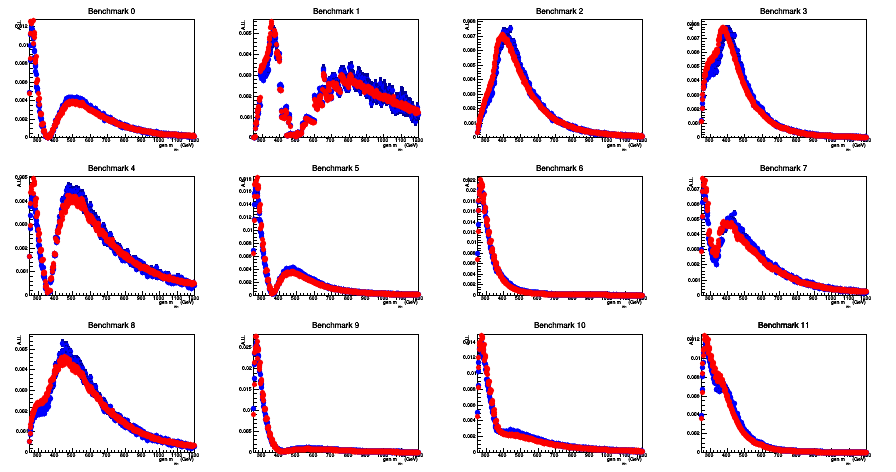

Info in <TCanvas::Print>: pdf file /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/reweighted_nodes/2016_2017/gendiHiggs_mass_2016_2017_12_02_2018.pdf has been created


In [21]:
sum=0.
c = TCanvas("c","c",900,500)
c.Divide(4,3)
name='GluGluToHHTo2B2G_reweighted'
filename  = 'output_GluGluToHHTo2B2G_mixReweightedNodes_13TeV-madgraph'
infile = TFile(file_dir+filename+'_2016.root')
infile_2017 = TFile(file_dir+filename+'_correctedcfg_2017.root')
hists_list=[]
hists_list_2017=[]
#benchmarks_2016 = [2,3,4,7,9,12]
reco_gen = ['','_GenAll']
which_reco_gen = 1
diHiggs_mass = ['diHiggs_mass','mhh']
i=0
for num_node in range(0,12):
    c.cd(i+1)
    tree_2017 = infile_2017.Get(name+reco_gen[which_reco_gen])
    hist_2017 = TH1F("hist_2017_%d"%num_node,"hist_2017_%d"%num_node,500,250,1200)
    hist_2017.SetLineColor(2)
    hist_2017.SetMarkerColor(2)
    tree_2017.Draw("%s>>hist_2017_%d"%(diHiggs_mass[which_reco_gen],num_node),"weight*benchmark_reweight_%d"%num_node)
    hist_2017.Scale(1./hist_2017.Integral())
    
    tree = infile.Get(name+reco_gen[which_reco_gen])
    hist = TH1F("hist_2016_%d"%num_node,"hist_2016_%d"%num_node,500,250,1200)
    hist.SetTitle("Benchmark %d"%(num_node))
    if which_reco_gen ==0 : hist.GetXaxis().SetTitle('reco m_{HH} (GeV)')
    else : hist.GetXaxis().SetTitle('gen m_{HH} (GeV)')

    hist.GetYaxis().SetTitle('A.U.')
    ROOT.gStyle.SetOptTitle(1)
    ROOT.gStyle.SetOptStat(0)
    tree.Draw("%s>>hist_2016_%d"%(diHiggs_mass[which_reco_gen],num_node),"weight*benchmark_reweight_%d"%num_node)
    hist.Scale(1./hist.Integral())

    
    hist.Draw("APsame")
    hists_list.append(hist)
    hist_2017.Draw("same")
    hists_list_2017.append(hist_2017)
    i+=1
c.Draw()
if which_reco_gen ==0 : c.SaveAs(plot_dir+'recodiHiggs_mass_2016_2017_'+date+'.pdf')
else : c.SaveAs(plot_dir+'gendiHiggs_mass_2016_2017_'+date+'.pdf')